In [17]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
from keras import regularizers
import matplotlib.pyplot as plt

In [18]:
X_test = np.load("Data/X_test.npy")
y_test = np.load("Data/y_test.npy")
person_train_valid = np.load("Data/person_train_valid.npy")
X_train_valid = np.load("Data/X_train_valid.npy")
y_train_valid = np.load("Data/y_train_valid.npy")
person_test = np.load("Data/person_test.npy")

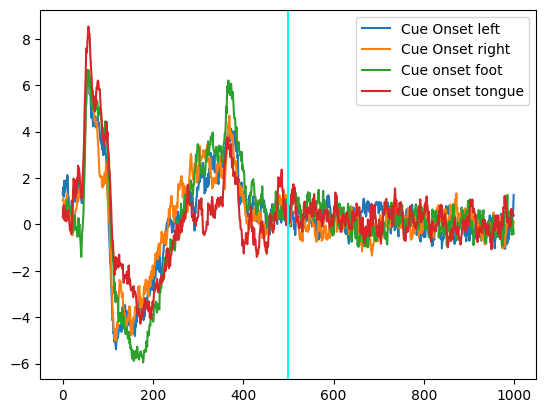

In [19]:
y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [20]:
X_train_valid = X_train_valid[:,:,0:500]
X_test = X_test[:,:,0:500]

In [21]:
## Preprocessing the dataset

X_train_valid_prep = X_train_valid[:,:,0:500]
X_test_prep = X_test[:,:,0:500]



print(X_train_valid_prep.shape)
print(y_train_valid.shape)
print(X_test_prep.shape)
print(y_test.shape)



## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 500, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid]
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

(2115, 22, 500)
(2115,)
(443, 22, 500)
(443,)
Shape of training set: (1615, 22, 500)
Shape of validation set: (500, 22, 500)
Shape of training labels: (1615,)
Shape of validation labels: (500,)
Shape of training labels after categorical conversion: (1615, 4)
Shape of validation labels after categorical conversion: (500, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (1615, 22, 500, 1)
Shape of validation set after adding width info: (500, 22, 500, 1)
Shape of test set after adding width info: (443, 22, 500, 1)
Shape of training set after dimension reshaping: (1615, 500, 1, 22)
Shape of validation set after dimension reshaping: (500, 500, 1, 22)
Shape of test set after dimension reshaping: (443, 500, 1, 22)


In [22]:
# First model: largely based on discussion model, but no data augmentation and using simple cropping instead
hybrid_cnn_lstm_model = Sequential()

# Conv. block 1
hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(5,5), padding='same', activation='elu', input_shape=(500,1,22)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 2
hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 3
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 4
hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# FC+LSTM layers
hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_lstm_model.add(Dense((40))) # FC layer with 100 units
hybrid_cnn_lstm_model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible
hybrid_cnn_lstm_model.add(LSTM(10, dropout=0.4, recurrent_dropout=0.1, input_shape=(40,1), return_sequences=False))

# Output layer with Softmax activation 
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

# Printing the model summary
hybrid_cnn_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 500, 1, 25)        13775     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 167, 1, 25)        0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 167, 1, 25)        100       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 167, 1, 25)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 167, 1, 50)        31300     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 1, 50)        

In [23]:
learning_rate = 1e-3
epochs = 100
hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(learning_rate = learning_rate)

In [24]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=8)

# Compiling the model
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             callbacks=[callback],
             validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/100
26/26 [==============================] - 11s 143ms/step - loss: 1.3928 - accuracy: 0.2495 - val_loss: 1.3846 - val_accuracy: 0.2340
Epoch 2/100
26/26 [==============================] - 3s 114ms/step - loss: 1.3819 - accuracy: 0.2824 - val_loss: 1.3785 - val_accuracy: 0.2780
Epoch 3/100
26/26 [==============================] - 3s 117ms/step - loss: 1.3748 - accuracy: 0.3046 - val_loss: 1.3637 - val_accuracy: 0.3520
Epoch 4/100
26/26 [==============================] - 3s 115ms/step - loss: 1.3651 - accuracy: 0.3139 - val_loss: 1.3394 - val_accuracy: 0.3340
Epoch 5/100
26/26 [==============================] - 3s 126ms/step - loss: 1.3517 - accuracy: 0.3319 - val_loss: 1.3259 - val_accuracy: 0.3320
Epoch 6/100
26/26 [==============================] - 3s 119ms/step - loss: 1.3404 - accuracy: 0.3356 - val_loss: 1.3023 - val_accuracy: 0.3460
Epoch 7/100
26/26 [==============================] - 3s 114ms/step - loss: 1.3275 - accuracy: 0.3517 - val_loss: 1.3215 - val_accuracy: 0.326

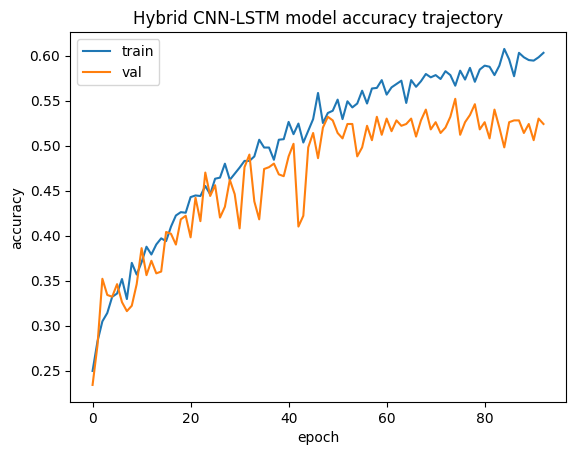

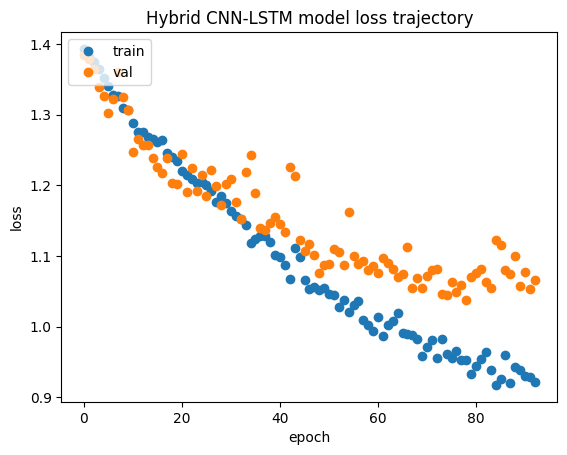

In [25]:
# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [26]:
hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Test accuracy of the basic hybrid CNN-LSTM model: 0.5079006552696228


In [27]:
p1_mask = (person_test == 1).flatten()
x_test = x_test[p1_mask]
y_test = y_test[p1_mask]

print(x_test.shape)
print(y_test.shape)

(50, 500, 1, 22)
(50, 4)


In [28]:
hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic hybrid CNN-LSTM model, single person:',hybrid_cnn_lstm_score[1])

Test accuracy of the basic hybrid CNN-LSTM model, single person: 0.4399999976158142


In [6]:
X_test = np.load("Data/X_test.npy")
y_test = np.load("Data/y_test.npy")
person_train_valid = np.load("Data/person_train_valid.npy")
X_train_valid = np.load("Data/X_train_valid.npy")
y_train_valid = np.load("Data/y_train_valid.npy")
person_test = np.load("Data/person_test.npy")

In [7]:
y_train_valid -= 769
y_test -= 769

In [8]:
def train_data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):
    
    total_X = None
    
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    
    
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X

In [9]:
## Preprocessing the dataset

X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep = test_data_prep(X_test) 

## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(8460, 1000, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of X after trimming: (2115, 22, 800)
Shape of X after maxpooling: (2115, 22, 400)
Shape of X after averaging+noise and concatenating: (4230, 22, 400)
Shape of X after subsampling and concatenating: (8460, 22, 400)
Shape of Y: (8460,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of training set: (7460, 22, 400)
Shape of validation set: (1000, 22, 400)
Shape of training labels: (7460,)
Shape of validation labels: (1000,)
Shape of training labels after categorical conversion: (7460, 4)
Shape of validation labels after categorical conversion: (1000, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (7460, 22, 400, 1)
Shape of validation set after adding width info: (1000, 22, 400, 1)
Shape of test set after adding width info: (443, 22, 400, 1)
Shape of training set after dimension reshaping: (7460, 400, 1, 22)
Shape of validation set after dimension reshaping: (1000, 400, 1, 22)

In [66]:
# Second model: trimming data 
hybrid_cnn_lstm_model2 = Sequential()

# Conv. block 1
hybrid_cnn_lstm_model2.add(Conv2D(filters=25, kernel_size=(5,5), kernel_regularizer=regularizers.L2(1e-3),
                                  padding='same', activation='elu', input_shape=(400,1,22)))
hybrid_cnn_lstm_model2.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model2.add(BatchNormalization())
hybrid_cnn_lstm_model2.add(Dropout(0.4))

# Conv. block 2
hybrid_cnn_lstm_model2.add(Conv2D(filters=50, kernel_size=(5,5), kernel_regularizer=regularizers.L2(1e-3),
                                  padding='same', activation='elu'))
hybrid_cnn_lstm_model2.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model2.add(BatchNormalization())
hybrid_cnn_lstm_model2.add(Dropout(0.4))

# Conv. block 3
hybrid_cnn_lstm_model2.add(Conv2D(filters=100, kernel_size=(5,5), kernel_regularizer=regularizers.L2(1e-3),
                                  padding='same', activation='elu'))
hybrid_cnn_lstm_model2.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model2.add(BatchNormalization())
hybrid_cnn_lstm_model2.add(Dropout(0.4))

# Conv. block 4
hybrid_cnn_lstm_model2.add(Conv2D(filters=200, kernel_size=(5,5), kernel_regularizer=regularizers.L2(1e-3),
                                  padding='same', activation='elu'))
hybrid_cnn_lstm_model2.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model2.add(BatchNormalization())
hybrid_cnn_lstm_model2.add(Dropout(0.4))

# FC+LSTM layers
hybrid_cnn_lstm_model2.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_lstm_model2.add(Dense((40))) # FC layer with 100 units
hybrid_cnn_lstm_model2.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible
hybrid_cnn_lstm_model2.add(LSTM(10, dropout=0.4, recurrent_dropout=0.1, input_shape=(40,1), return_sequences=False))

# Output layer with Softmax activation 
hybrid_cnn_lstm_model2.add(Dense(4, kernel_regularizer=regularizers.L2(1e-3), activation='softmax')) # Output FC layer with softmax activation

# Printing the model summary
hybrid_cnn_lstm_model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 400, 1, 25)        13775     
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 134, 1, 25)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_29 (Ba  (None, 134, 1, 25)        100       
 tchNormalization)                                               
                                                                 
 dropout_29 (Dropout)        (None, 134, 1, 25)        0         
                                                                 
 conv2d_30 (Conv2D)          (None, 134, 1, 50)        31300     
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 45, 1, 50)        

In [67]:
learning_rate = 1e-3
epochs = 100
hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(learning_rate = learning_rate)

In [68]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Compiling the model
hybrid_cnn_lstm_model2.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results2 = hybrid_cnn_lstm_model2.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             callbacks=[callback],
             validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/100
117/117 [==============================] - 21s 109ms/step - loss: 1.4456 - accuracy: 0.3145 - val_loss: 1.3990 - val_accuracy: 0.3520
Epoch 2/100
117/117 [==============================] - 12s 103ms/step - loss: 1.3327 - accuracy: 0.4158 - val_loss: 1.2618 - val_accuracy: 0.4870
Epoch 3/100
117/117 [==============================] - 12s 101ms/step - loss: 1.2510 - accuracy: 0.4831 - val_loss: 1.1767 - val_accuracy: 0.5200
Epoch 4/100
117/117 [==============================] - 12s 102ms/step - loss: 1.1966 - accuracy: 0.5034 - val_loss: 1.1303 - val_accuracy: 0.5400
Epoch 5/100
117/117 [==============================] - 12s 104ms/step - loss: 1.1547 - accuracy: 0.5406 - val_loss: 1.0091 - val_accuracy: 0.6120
Epoch 6/100
117/117 [==============================] - 11s 97ms/step - loss: 1.1072 - accuracy: 0.5660 - val_loss: 1.0786 - val_accuracy: 0.5700
Epoch 7/100
117/117 [==============================] - 11s 96ms/step - loss: 1.0970 - accuracy: 0.5771 - val_loss: 1.0108 - v

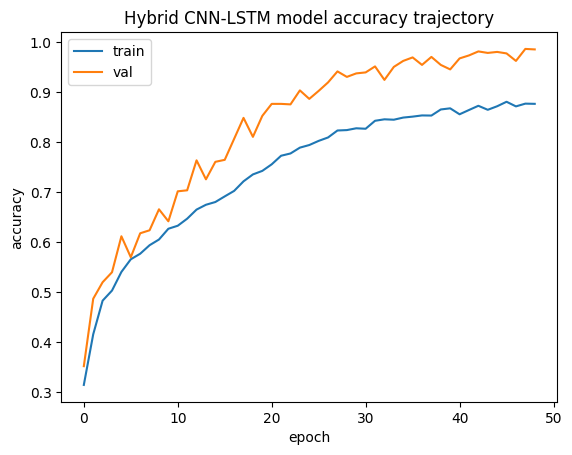

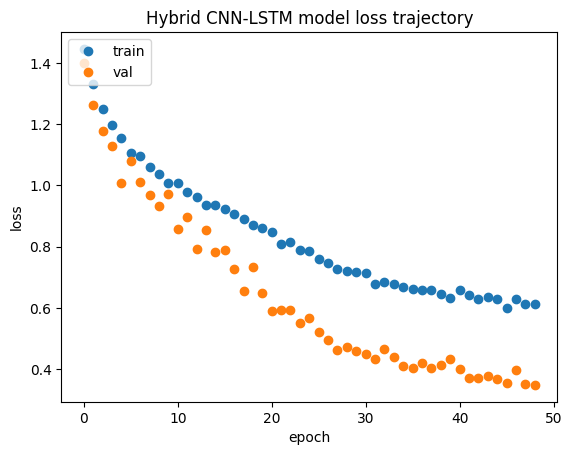

In [69]:
# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results2.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results2.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results2.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results2.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [70]:
hybrid_cnn_lstm_score2 = hybrid_cnn_lstm_model2.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score2[1])

Test accuracy of the hybrid CNN-LSTM model: 0.690744936466217


In [83]:
p1_mask = (person_test == 1).flatten()
x_test = x_test[p1_mask]
y_test = y_test[p1_mask]

print(x_test.shape)
print(y_test.shape)

(50, 400, 1, 22)
(50, 4)


In [72]:
hybrid_cnn_lstm_score2 = hybrid_cnn_lstm_model2.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model, single person:',hybrid_cnn_lstm_score2[1])

Test accuracy of the hybrid CNN-LSTM model, single person: 0.5400000214576721
